In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams as rc

In [39]:
traj=np.load('../data/trajectory/traj_Rouse_chain_unconfined_T1.0_F1.0_Ta50.0_Esoft0_R00_Na200_blocksize10_positions.npy')
# traj=np.load('../Rouse_chain/traj_Confined_Rouse_chain_T0.1_F1.0_Ta10.0_Esoft0_R017_Na200_blocksize10_positions.npy')

In [31]:
traj.shape

(490000, 400, 3)

In [40]:
pol1=traj[:,0:100,:]
pol2=traj[:,100:200,:]
pol3=traj[:,200:300,:]
pol4=traj[:,300:400,:]
N=pol1.shape[1]
kb=10
print(pol1.shape,pol2.shape,pol3.shape,pol4.shape)

(490000, 100, 3) (490000, 100, 3) (490000, 100, 3) (490000, 100, 3)


In [113]:
def autocorrFFT(x):
  Nx=len(x)
  F = np.fft.fft(x, n=2*Nx)  #2*N because of zero-padding
  PSD = F * F.conjugate()
  res = np.fft.ifft(PSD)
  res= (res[:Nx]).real   #now we have the autocorrelation in convention B
  n=Nx*np.ones(Nx)-np.arange(0,Nx) #divide res(m) by (N-m)
  return res/n #this is the autocorrelation in convention A

def msd_fft(r):
  Nx=len(r)
  D=np.square(r).sum(axis=1) 
  D=np.append(D,0) 
  S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
  Q=2*D.sum()
  S1=np.zeros(Nx)
  for m in range(Nx):
      Q=Q-D[m-1]-D[Nx-m]
      S1[m]=Q/(Nx-m)
  return S1,S2

def tau_p(pp,T):
  Nn=500
  res=0.1*(Nn/pp)**2/(3*T*np.pi**2)
  # res=0.1*(N/pp)**2/(np.pi**2*kb)
  return res


def rabin_msd(t,nn,T,F1,ta):
  
    g=0.1
    # ta=10
    # nn=N/3
    F=6*F1**2
    t1=g*N**2/(3*np.pi**2*T)
    res=(6*T*t/(N*g)
        +(6*F*ta/(N*g**2))*(ta*(np.exp(-t/ta)-1)+t)
        +sum([(12*T*t1/(N*g*pp**2))*(1-np.exp(-pp**2*t/t1))*np.cos(pp*np.pi*nn/N)**2 
            for pp in range(1,N)])
        +sum([(24*F*t1*ta/(N*g**2*pp**2*(1-(pp**2*ta/t1)**2)))*(1-np.exp(-pp**2*t/t1)+(pp**2*ta/t1)*(np.exp(-t/ta)-1))*np.cos(pp*np.pi*nn/N)**2 
            for pp in range(1,N)]))
    return res

def mode_corr(t,F,T,ta,pp):
    g=0.1
    # N/(6*np.pi**2*pp**2)
    # xp2=N*T/(2*np.pi**2*kb*pp**2)
    xp2_act= (3*(F*ta*tau_p(pp,T))**2/((2*N*g**2)*(ta**2-tau_p(pp,T)**2)))*(tau_p(pp,T)*np.exp(-t/tau_p(pp,T))/ta+np.exp(-t/ta))
    # (3*F**2/(N*g**2))*ta*tau_p(pp,T)*(np.exp(-t/tau_p(pp,T))+(ta/tau_p(pp,T))*np.exp(-t/ta))/((1-ta/tau_p(pp,T))*(1+ta/tau_p(pp,T)))
    xp2_pas=(3*T*tau_p(pp,T)/(2*N*g))*np.exp(-t/tau_p(pp,T))
    return xp2_act+xp2_pas

In [41]:
dt=0.001
bl=10
ts=np.arange(0,pol1.shape[0],1)*dt*bl

Sp_act=[]
Sp_pas=[]

p_vals=[1,2,3,5]

for pp in p_vals:
    res1,res2=[],[]
    for jj, polx in enumerate([pol1,pol2]):
        Xp_act = (1/N)*np.einsum('ijk,j->ik',polx,np.cos((pp*np.pi/N)*(np.arange(1,N+1,1))))
        res1.append(msd_fft(Xp_act)[1])

    for jj,polx in enumerate([pol3,pol4]):
        Xp_pas = (1/N)*np.einsum('ijk,j->ik',polx,np.cos((pp*np.pi/N)*(np.arange(1,N+1,1))))
        res2.append(msd_fft(Xp_pas)[1])
    
    print(np.mean(res1,axis=0).shape)
    Sp_act.append(np.mean(res1,axis=0))
    Sp_pas.append(np.mean(res2,axis=0))

(490000,)
(490000,)
(490000,)
(490000,)


8.443431970194816


Text(0.5, 1.0, '${\\rm T}=1$  $F=0$  $\\tau_a=30$')

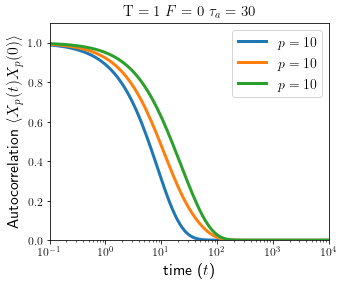

In [129]:
tt=np.logspace(-5,4,200)
rc['text.usetex']=True
rc['figure.figsize']=(5,4)
rc['font.size']=12
TT=1
TA=30
for ii,pp in enumerate([10]):
    # if pp!=5: continue
    # plt.semilogx(ts,Sp_act[ii]/Sp_act[ii][0],'.',label='active($p = {}$)'.format(pp),alpha=0.5)
    # plt.semilogx(ts,Sp_pas[ii]/Sp_pas[ii][0],'.',label='passive($p = {}$)'.format(pp),alpha=0.5)
    
    # plt.semilogx(ts, mode_corr(ts,1,1e-2,10,pp)/mode_corr(0,1,1e-2,10,pp),'k--',label='active ($p = {}$)'.format(pp))
    # plt.semilogx(ts,np.exp(-ts/10),'k--')
    for FF in [ 0.01, 0.1 ,1]:
        plt.semilogx(tt, mode_corr(tt,FF,TT,TA,pp)/mode_corr(0,FF,TT,TA,pp),label='$p = {}$'.format(pp),lw=3)
    # plt.axvline(tau_p(pp,0.01),c='k',ls='--')
    print(tau_p(pp,TT))
# plt.semilogx(ts,np.exp(-(ts/tp)),'b--')
# plt.semilogx(ts,np.exp(-(ts/15)**1.6),'r--')
# plt.loglog()
plt.xlim(1e-1,1e4)
# plt.ylim(-0.1,1.1)
plt.ylim(0,1.1)
plt.legend(loc='upper right',fontsize=14, ncol=1)
plt.ylabel('Autocorrelation $\\langle X_p(t)X_p(0)\\rangle$',fontsize=16)
plt.xlabel('time ($t$)',fontsize=16)
plt.title('${\\rm T}=1$  $F=0$  $\\tau_a=30$',fontsize=15)

# plt.savefig('../plots/AutoCorr_RC_theory_highp_passive.png',dpi=300)


In [56]:
plt.loglog(ts,s1[0]-2*s1[1],'g.')
plt.loglog(ts,s3[0]-2*s3[1],'m.')
plt.loglog(ts,rabin_pred(ts,1,0,10),'m--')
plt.loglog(ts,rabin_pred(ts,60,1,10),'g--')
plt.ylim([1e-3,2e4])

NameError: name 's1' is not defined

In [138]:
(3*np.pi**2*0.01*10/0.1)**0.25

2.3326804523343214

In [25]:
pol1_bonds=pol1[:,1:100,:]-pol1[:,0:99,:]
pol3_bonds=pol3[:,1:100,:]-pol3[:,0:99,:]
print(pol1_bonds.shape,pol3_bonds.shape)

(490000, 99, 3) (490000, 99, 3)


In [26]:
pol1_bonlen=np.linalg.norm(pol1_bonds,axis=2)
pol3_bonlen=np.linalg.norm(pol3_bonds,axis=2)

print(pol1_bonlen.shape,pol3_bonlen.shape)

(490000, 99) (490000, 99)


In [27]:
hist1,bin_edges=np.histogram(pol1_bonlen.flatten(),bins=np.linspace(0,5,100),density=True)
hist3,bin_edges=np.histogram(pol3_bonlen.flatten(),bins=np.linspace(0,5,100),density=True)
print(hist1.shape)

(99,)


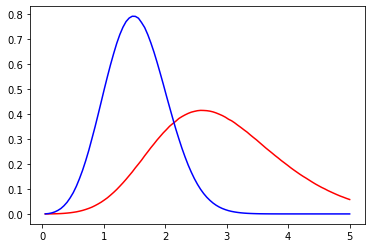

In [29]:
bs=np.linspace(0,5,100)
plt.plot(bin_edges[1:],hist1,'r')
plt.plot(bin_edges[1:],hist3,'b')
# plt.plot(bs,np.exp(-0.5*(10/0.01)*(bs-1)**2))

In [25]:
for fname in os.listdir('./'):
    if '.npz' in fname:
        data=np.load(fname)
        print(data.files,data['SXp'].shape)
        

['SXp', 'p'] (8, 989901)


In [31]:
np.stack(([4,4],[4,5]),axis=0).shape

(2, 2)